In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Sensor():
  def __init__(self,time, x, y, z, vx, vy, vz, q1, q2, q3, q4, wx, wy, wz):
    self.time = pd.to_datetime(time)
    self.position = np.array([x, y, z])
    self.velocity = np.array([vx, vy, vz])
    self.quaternions = np.array([q1, q2, q3, q4])
    self.angular_velocity = np.array([wx, wy, wz])
    self.Cbi = self.get_Cbi()
  
  def get_Cbi(self):
    q = self.quaternions
    if q[3] < 0:
      q = -q
    q0, q1, q2, q3 = q
    Msi = np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                    [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                    [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]])
    return Msi.T
  
  def update_gyro(self, wb, bias=0,noise=0.05*3600):#bias deg/h, noise deg/h (std, mean)
    gyro_bias = np.deg2rad(bias*np.ones(3))/3600
    gyro_noise = np.deg2rad(noise*np.random.randn(3))/3600
    self.gyro = wb + gyro_bias + gyro_noise
    self.gyro = self.Cbi @ self.gyro
    self.gyro = np.rad2deg(self.gyro)
    #print(self.gyro)

  def update_acc(self, acc, bias =0 ,noise=500):# output m/s^2, input: ug==10^-5 m/s^2
    acc_bias = bias*1e-5*np.ones(3)
    acc_noise = noise*1e-5*np.random.randn(3)
    self.acc = acc + acc_bias + acc_noise
    self.acc = self.Cbi @ self.acc
    #print(self.acc)
  
  def get_acc(self):
    return self.acc
  def get_gyro(self):
    return self.gyro

In [8]:
def read_sensor_data(sensor_file):
  sensor_data = pd.read_csv(sensor_file)
  time_list = pd.to_datetime(sensor_data['Time (UTCG)']).to_list()
  sensor=[]
  for sensor_ in sensor_data.iterrows():
    sensor_temp = Sensor(sensor_[1]['Time (UTCG)'],sensor_[1]['x (km)'],sensor_[1]['y (km)'],sensor_[1]['z (km)'],sensor_[1]['Velocity x (km/sec)'],sensor_[1]['Velocity y (km/sec)'],sensor_[1]['Velocity z (km/sec)'],sensor_[1]['q1'],sensor_[1]['q2'],sensor_[1]['q3'],sensor_[1]['q4'],sensor_[1]['wx (deg/sec)'],sensor_[1]['wy (deg/sec)'],sensor_[1]['wz (deg/sec)'])
    sensor.append(sensor_temp)
  return sensor, time_list
sensor, time_list = read_sensor_data('data/mysenior_sensor_data_output.csv')

In [9]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])
def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

In [10]:
def j2_perturbation_acceleration(r, mu=3.986004418e14, J2=1.08262668e-3, Re=6378137):
    rx, ry, rz = r
    r_norm = np.linalg.norm(r)  # 位置矢量模
    # 计算公共项
    re_over_r = Re / r_norm
    re_over_r_sq = re_over_r**2
    rz_over_r = rz / r_norm
    rz_over_r_sq = rz_over_r**2
    # J2修正因子（注意x/y与z分量的差异）
    factor_xy = 1 + (3/2) * J2 * re_over_r_sq * (1 - 5 * rz_over_r_sq)
    factor_z  = 1 + (3/2) * J2 * re_over_r_sq * (3 - 5 * rz_over_r_sq)
    #加速度计算
    scale = -mu/(r_norm**3)
    ax = scale * factor_xy * rx
    ay = scale * factor_xy * ry
    az = scale * factor_z  * rz
    
    return np.array([ax, ay, az])

In [11]:
true_omega = []
true_accel = []
for i in range(len(sensor)-2):
  sensor0 = sensor[i]
  sensor1 = sensor[i+1]
  sensor2 = sensor[i+2]
  time_diff = (sensor1.time - sensor0.time).total_seconds()
  dq = (sensor1.quaternions - sensor0.quaternions)/time_diff
  conjq = quaternion_conjugate(sensor0.quaternions)
  wb = 2*quaternion_multiply(dq, conjq)[1:]
  # print(wb)
  Sensor.update_gyro(sensor0,wb)
  a_i = (sensor2.position + sensor0.position - 2*sensor1.position)*1000/time_diff**2
  g_i = j2_perturbation_acceleration(sensor0.position*1000)
  # mu = 3.986004418e14
  # g_i = -mu/np.linalg.norm(sensor0.position*1000)**3*sensor0.position*1000
  Sensor.update_acc(sensor0, a_i-g_i)
  true_omega.append(wb)
  true_accel.append(a_i-g_i)
true_omega = np.array(true_omega)
true_accel = np.array(true_accel)

In [ ]:
import numpy as np

class IMUErrorModel:
    def __init__(self, dt):
        self.dt = dt
        
        # Gyroscope parameters
        self.N_b_gyro = 0.8 / (3600 * np.sqrt(3600))  # Bias instability noise density (°/s/√Hz)
        self.N_arw = 0.09 / np.sqrt(3600)            # ARW noise density (°/s/√Hz)
        self.N_wn_gyro = 0.002                       # White noise density (°/s/√Hz)
        
        # Accelerometer parameters
        self.N_b_accel = 3.14e-5 / np.sqrt(3600)     # Bias instability noise density (m/s²/√Hz)
        self.N_vrw = 0.008 / np.sqrt(3600)           # VRW noise density (m/s²/√Hz)
        self.N_wn_accel = 0.004905                   # White noise SD (m/s²)
        
        # Initialize biases
        self.b_gyro = 0.0
        self.b_accel = 0.0
        
    def update_biases(self):
        # Update bias with random walk
        self.b_gyro += self.N_b_gyro * np.sqrt(self.dt) * np.random.randn()
        self.b_accel += self.N_b_accel * np.sqrt(self.dt) * np.random.randn()
        
    def get_gyro_noise(self):
        arw = self.N_arw * np.sqrt(self.dt) * np.random.randn()
        wn_gyro = self.N_wn_gyro * np.sqrt(self.dt) * np.random.randn()
        return self.b_gyro + arw + wn_gyro
    
    def get_accel_noise(self):
        vrw = self.N_vrw * np.sqrt(self.dt) * np.random.randn()
        wn_accel = self.N_wn_accel * np.random.randn()
        return self.b_accel + vrw + wn_accel

# 使用示例
dt = 0.1  # 假设采样频率为4.25 kHz
imu = IMUErrorModel(dt)

# 每次采样时更新
imu.update_biases()
omega_meas = true_omega + imu.get_gyro_noise()
a_meas = true_accel + imu.get_accel_noise()

# import numpy as np

# class IMUErrorModel:
#     def __init__(self, dt, config_bit7=1):
#         self.dt = dt
        
#         # Gyroscope parameters
#         self.N_b_gyro = 0.8 / (3600 * np.sqrt(3600))  # Bias instability noise density (°/s/√Hz)
#         self.N_arw = 0.09 / np.sqrt(3600)            # ARW noise density (°/s/√Hz)
#         self.N_wn_gyro = 0.002                       # White noise density (°/s/√Hz)
#         self.K_la = 0.006 if config_bit7 == 1 else 0.015  # 线性加速度效应系数 (°/sec/g)
        
#         # Accelerometer parameters
#         self.N_b_accel = 3.14e-5 / np.sqrt(3600)     # Bias instability noise density (m/s²/√Hz)
#         self.N_vrw = 0.008 / np.sqrt(3600)           # VRW noise density (m/s²/√Hz)
#         self.N_wn_accel = 0.004905                   # White noise SD (m/s²)
        
#         # Initialize biases
#         self.b_gyro = 0.0
#         self.b_accel = 0.0
        
#     def update_biases(self):
#         # 更新零偏（随机游走过程）
#         self.b_gyro += self.N_b_gyro * np.sqrt(self.dt) * np.random.randn()
#         self.b_accel += self.N_b_accel * np.sqrt(self.dt) * np.random.randn()
        
#     def get_gyro_noise(self, a_true_m_s2):
#         # 计算线性加速度效应（需将加速度转换为g单位）
#         a_true_g = a_true_m_s2 / 9.81  # 转换为g单位
#         la_effect = self.K_la * a_true_g  # 线性加速度引起的误差
        
#         # 随机噪声项
#         arw = self.N_arw * np.sqrt(self.dt) * np.random.randn()
#         wn_gyro = self.N_wn_gyro * np.sqrt(self.dt) * np.random.randn()
        
#         return self.b_gyro + la_effect + arw + wn_gyro
    
#     def get_accel_noise(self):
#         # 加速度计噪声模型（与之前相同）
#         vrw = self.N_vrw * np.sqrt(self.dt) * np.random.randn()
#         wn_accel = self.N_wn_accel * np.random.randn()
#         return self.b_accel + vrw + wn_accel

# # 使用示例
# dt = 0.1  # 假设采样频率为4.25 kHz
# imu = IMUErrorModel(dt, config_bit7=1)

# # 仿真时需传入当前真实加速度（以m/s²为单位）
# true_accel_m_s2 = 0  # 假设当前真实加速度为2.0 m/s²

# # 每次采样时更新
# imu.update_biases()
# omega_meas = true_omega + imu.get_gyro_noise(a_true_m_s2=true_accel_m_s2)
# a_meas = true_accel + imu.get_accel_noise()

In [12]:
#plt.plot(true_omega, label='True Omega')
plt.plot(omega_meas, label='Measured Omega')
plt.xlabel('Sample Index')
plt.ylabel('Angular Velocity (°/s)')
plt.title('True vs Measured Angular Velocity')
plt.legend()
plt.grid()
plt.show()
#plt.plot(true_accel, label='True Acceleration')
plt.plot(a_meas, label='Measured Acceleration')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (m/s²)')
plt.title('True vs Measured Acceleration')
plt.legend()
plt.grid()
plt.show()

NameError: name 'omega_meas' is not defined

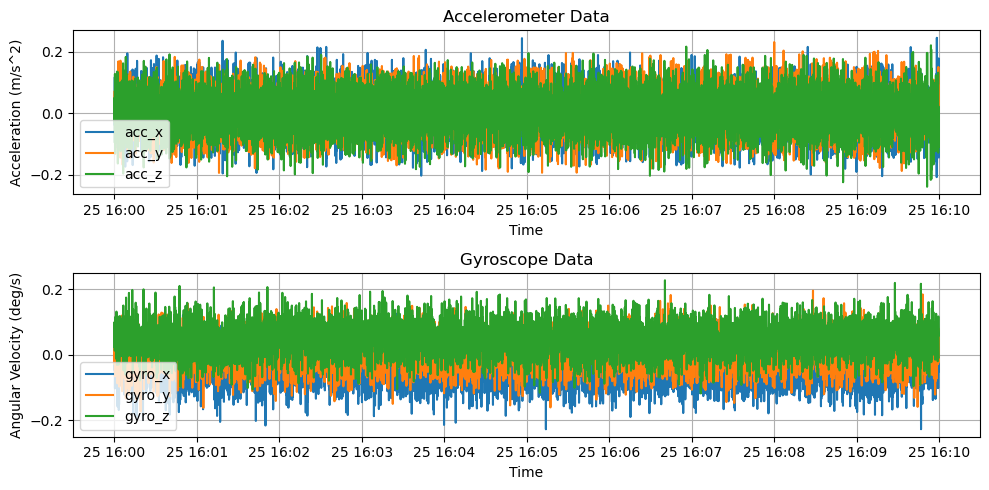

In [13]:
acc_list = []
gyro_list = []
for i in range(len(sensor)-2):
  acc_list.append(sensor[i].get_acc())
  gyro_list.append(sensor[i].get_gyro())
acc_list = np.array(acc_list)
gyro_list = np.array(gyro_list)
columns = ['time', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
df = pd.DataFrame(columns=columns)
df['time'] = time_list[:-2]
df['acc_x'] = acc_list[:,0]
df['acc_y'] = acc_list[:,1]
df['acc_z'] = acc_list[:,2]
df['gyro_x'] = gyro_list[:,0]
df['gyro_y'] = gyro_list[:,1]
df['gyro_z'] = gyro_list[:,2]
df.to_csv('imudata.csv',index=False)
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(df['time'], df['acc_x'], label='acc_x')
plt.plot(df['time'], df['acc_y'], label='acc_y')
plt.plot(df['time'], df['acc_z'], label='acc_z')
plt.title('Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(df['time'], df['gyro_x'], label='gyro_x')
plt.plot(df['time'], df['gyro_y'], label='gyro_y')
plt.plot(df['time'], df['gyro_z'], label='gyro_z')
plt.title('Gyroscope Data')
plt.xlabel('Time')
plt.ylabel('Angular Velocity (deg/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [8]:
# 验证毕卡
def skew_4(v):
  x,y,z = v
  return np.array([[0,-x,-y,-z],[x,0,z,y],[y,-z,0,x],[z,-y,-x,0]]) #???return np.array([[0,-x,-y,-z],[x,0,z,-y],[y,-z,0,x],[z,y,-x,0]])

def picard(Q, delta_A):
  delta_theta = skew_4(delta_A)
  delta_A_mod = np.linalg.norm(delta_A)
  update_Q = np.eye(4)*np.cos(delta_A_mod/2) + delta_theta*np.sin(delta_A_mod/2)/delta_A_mod
  return update_Q @ Q

def get_Cbi(q): #C_bi
  if q[3] < 0:
    q = -q
  q0, q1, q2, q3 = q
  Msi = np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                  [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                  [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]])
  return Msi.T
def get_attitude_angle(Msi): #return radiants
  phi = np.arctan2(Msi[2,1], Msi[2,2])
  theta = np.arctan2(-Msi[2,0], np.sqrt(Msi[2,1]**2 + Msi[2,2]**2))
  psi = np.arctan2(Msi[1,0], Msi[0,0])
  return phi, theta, psi

mu = 3.986004418e14
lastQ = sensor[0].quaternions
for i in range(len(sensor)-2):
  sensor0 = sensor[i]
  sensor1 = sensor[i+1] 
  time_diff = (sensor1.time - sensor0.time).total_seconds()
  dq = (sensor1.quaternions - sensor0.quaternions)/time_diff
  conjq = quaternion_conjugate(sensor0.quaternions)
  wb = 2*quaternion_multiply(dq, conjq)[1:]
  # wb = np.array([0,-np.sqrt(mu/np.linalg.norm(sensor0.position*1000)**3),0])
  Cbi = get_Cbi(lastQ)
  wb = Cbi @ np.rad2deg(wb)
  delta_A = Cbi.T @np.deg2rad(wb*0.1)
  #delta_A = wb*0.1
  print(delta_A)
  lastQ = picard(lastQ, delta_A)
  # print(lastQ-sensor1.quaternions)

[-7.83021198e-07 -1.14028101e-04 -1.95544299e-07]
[ 1.28702197e-06 -1.13073547e-04 -5.86548898e-07]
[-7.83043198e-07 -1.14028193e-04 -1.95662299e-07]
[ 4.47384685e-07 -1.14364847e-04  6.43996986e-07]
[-1.23467789e-06 -1.11897125e-04 -1.08953167e-06]
[ 4.47286684e-07 -1.14364863e-04  6.44092986e-07]
[ 3.93304602e-07 -1.11506693e-04 -1.34612206e-07]
[ 4.47242684e-07 -1.14364761e-04  6.44094986e-07]
[-7.82947198e-07 -1.14028473e-04 -1.95912300e-07]
[-4.23400653e-09 -1.12233104e-04 -2.49762382e-07]
[-7.82951198e-07 -1.14028635e-04 -1.95956300e-07]
[ 1.28731397e-06 -1.13073159e-04 -5.85786896e-07]
[ 4.47026684e-07 -1.14364723e-04  6.44212986e-07]
[-4.47002684e-07 -1.12798849e-04  1.09543968e-06]
[-4.12400636e-09 -1.12232574e-04 -2.49792382e-07]
[-7.82855198e-07 -1.14028915e-04 -1.96206300e-07]
[ 1.28751997e-06 -1.13072977e-04 -5.85450896e-07]
[-7.82877198e-07 -1.14029007e-04 -1.96324300e-07]
[ 4.46836684e-07 -1.14364563e-04  6.44380986e-07]
[ 5.79460888e-08 -1.12737383e-04 -1.42606018e-06]


In [9]:
# 验证位置更新
initial_pos = [-1259.842691,6335.726319,-2024.004255]
initial_v = [-5.632442,-2.571912,-4.533970]
last_v = initial_v
last_pos = initial_pos
for i in range(len(sensor)-2):
  sensor0 = sensor[i]
  sensor1 = sensor[i+1]
  sensor2 = sensor[i+2]
  time_diff = (sensor1.time - sensor0.time).total_seconds()
  a_i = (sensor2.position + sensor0.position - 2*sensor1.position)/time_diff**2
  #g_1 Msi
  last_v = last_v + a_i*0.1
  last_pos = last_pos + last_v*0.1 + 0.5*a_i*0.1**2
  print(last_pos,sensor1.position)


[-1260.4059112  6335.4690063 -2024.457613 ] [-1260.405927  6335.469087 -2024.457639]
[-1260.9691154  6335.2116111 -2024.910945 ] [-1260.969147  6335.211774 -2024.910997]
[-1261.5323036  6334.9541354 -2025.364251 ] [-1261.532351  6334.954379 -2025.364329]
[-1262.0954743  6334.6965772 -2025.817531 ] [-1262.095539  6334.696903 -2025.817635]
[-1262.6586295  6334.43894   -2026.270785 ] [-1262.65871   6334.439345 -2026.270915]
[-1263.2217687  6334.1812183 -2026.724013 ] [-1263.221865  6334.181707 -2026.724169]
[-1263.7848904  6333.9234181 -2027.177215 ] [-1263.785004  6333.923986 -2027.177397]
[-1264.3479981  6333.6655349 -2027.6303895] [-1264.348126  6333.666185 -2027.630599]
[-1264.9110878  6333.4075697 -2028.08354  ] [-1264.911233  6333.408302 -2028.083774]
[-1265.474162  6333.149524 -2028.536664] [-1265.474323  6333.150337 -2028.536924]
[-1266.0372187  6332.8913973 -2028.9897605] [-1266.037397  6332.892291 -2028.990048]
[-1266.6002599  6332.6331896 -2029.442833 ] [-1266.600454  6332.6341